In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from collections import Counter

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import dill
import pandas as pd
import polars as pl
import numpy as np
from scipy.sparse import csr_matrix

# boosting
import lightgbm as lgb

import pytorch_lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from tasks.data.dataset.mappers import EntityEncoder
from tasks.jobs import Splitter

In [3]:
from otto_utils import *
from otto_candidates_covisit import *

In [4]:
# load
val_df_train = pl.read_parquet(VALIDATION_PATH / "train.parquet", use_pyarrow=True)
val_df_valid_input = pl.read_parquet(VALIDATION_PATH / "valid.parquet", use_pyarrow=True)
val_df_valid_targets = pl.read_parquet(VALIDATION_PATH / "test_labels.parquet", use_pyarrow=True)

In [23]:
df_train = pl.read_parquet(TRAIN_PROCESSED, use_pyarrow=True)
df_test = pl.read_parquet(TEST_PROCESSED, use_pyarrow=True)

In [6]:
# Use top X for clicks, carts and orders
clicks_th = 15
carts_th  = 20
orders_th = 20

def get_top(df, th):
    return (
        df
        .with_column(pl.lit(1).alias("ones"))
        .with_column(pl.col("ones").cumsum().over("aid").alias("rank"))
        .filter(pl.col("rank") <= th)
    )

In [7]:
carts_orders = pl.read_parquet("__valid__covisit_carts_orders_all_v3.parquet")
buys2buys = pl.read_parquet("__valid__covisit_buys2buys_all_v4.parquet")
clicks = pl.read_parquet("__valid__covisit_clicks_all_v3.parquet")

In [9]:
carts_orders_top = get_top(carts_orders, carts_th)
buys2buys_top = get_top(buys2buys, orders_th)
clicks_top = get_top(clicks, clicks_th)

In [8]:
top_clicks = val_df_valid_input.filter(pl.col("type") == 0)["aid"].value_counts(sort=True)[:20]["aid"].to_list()
top_carts = val_df_valid_input.filter(pl.col("type") == 1)["aid"].value_counts(sort=True)[:20]["aid"].to_list()
top_orders = val_df_valid_input.filter(pl.col("type") == 2)["aid"].value_counts(sort=True)[:20]["aid"].to_list()

In [14]:
covisit_rec = CovisitationRecommender(
    df_top_k_buys=carts_orders_top,
    df_top_k_buy2buy=buys2buys_top,
    df_top_k_clicks=clicks_top,
    top_carts=top_carts,
    top_orders=top_orders,
    top_clicks=top_clicks,
)

In [11]:
test_df = val_df_valid_input.sort(["session", "ts"])
test_session_dict = test_df.groupby('session').agg([pl.list("aid"), pl.list("type")])
test_session_dict = dict(zip(test_session_dict["session"].to_list(),
                             tuple(zip(test_session_dict["aid"].to_list(), test_session_dict["type"].to_list()))
                        ))

In [15]:
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 20

for session_id, (session_aid_list, session_type_list) in tqdm(test_session_dict.items()):
    rec_items_clicks = covisit_rec.recommend_clicks(session_aid_list, session_type_list, topk)
    rec_items_carts = covisit_rec.recommend_carts(session_aid_list, session_type_list, topk)
    rec_items_buys = covisit_rec.recommend_buys(session_aid_list, session_type_list, topk)
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels_list = [
        " ".join(str(aid) for aid in rec_items)
        for rec_items in [rec_items_clicks, rec_items_carts, rec_items_buys]
    ]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

df_submission = pl.DataFrame(submission_dict)

100%|██████████| 1303355/1303355 [01:48<00:00, 12056.80it/s]


In [207]:
valid_stats = calc_valid_score(df_submission, topk=20)

validation score: 0.5553375772931675
recall per type: type
carts    0.3932
clicks   0.5155
orders   0.6430
dtype: float64


In [48]:
valid_stats.query("gt_count == 0")

,session_type,labels,session,type,ground_truth,hits,gt_count
1,11107743_carts,"[1243310, 731062, 984459, 224347, 1838173, 666...",11107743,carts,[],0,0
2,11107743_orders,"[1243310, 731062, 984459, 224347, 666582, 1843...",11107743,orders,[],0,0
5,11107744_orders,"[1556644, 1637748, 220086, 830498, 959553, 497...",11107744,orders,[],0,0
7,11107745_carts,"[670066, 1682122, 770581, 1733943, 29735, 4931...",11107745,carts,[],0,0
8,11107745_orders,"[670066, 1682122, 770581, 493104, 1733943, 138...",11107745,orders,[],0,0
...,...,...,...,...,...,...,...
89993,11147674_orders,"[11227, 736515, 1746078, 228037, 1847646, 5653...",11147674,orders,[],0,0
89995,11147675_carts,"[1603001, 839831, 254154, 1596897, 167895, 409...",11147675,carts,[],0,0
89996,11147675_orders,"[1603001, 1268065, 237586, 1596897, 254154, 83...",11147675,orders,[],0,0
89998,11147676_carts,"[696766, 1773622, 1452392, 406902, 1471638, 95...",11147676,carts,[],0,0


In [49]:
valid_stats.query("hits > 0 and gt_count > 0")

,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107743_clicks,"[1243310, 731062, 224347, 1838173, 666582, 631...",11107743,clicks,[224347],1,1
6,11107745_clicks,"[670066, 1682122, 770581, 1733943, 29735, 4931...",11107745,clicks,[549612],1,1
12,11107747_clicks,"[618078, 1368814, 543120, 13046, 1006198, 3993...",11107747,clicks,[618078],1,1
15,11107748_clicks,"[1154005, 1113901, 1643860, 86356, 1158280, 31...",11107748,clicks,[1551520],1,1
18,11107749_clicks,"[636540, 153565, 1021440, 1691486, 341291, 700...",11107749,clicks,[153565],1,1
...,...,...,...,...,...,...,...
89972,11147664_orders,"[555367, 864727, 1842206, 170275, 1111474, 588...",11147664,orders,"[864727, 926901, 1030009, 1591605, 1700703]",1,5
89973,11147666_clicks,"[1469891, 1008624, 1460571, 1006790, 331708, 5...",11147666,clicks,[1008624],1,1
89977,11147668_carts,"[565742, 1654368, 513861, 783917, 538308, 6284...",11147668,carts,[565742],1,1
89983,11147670_carts,"[1275640, 1394665, 1482103, 794275, 1697926, 4...",11147670,carts,"[65259, 1482103]",1,2


In [50]:
valid_stats.query("hits == 0 and gt_count > 0")

,session_type,labels,session,type,ground_truth,hits,gt_count
3,11107744_clicks,"[1556644, 1637748, 220086, 830498, 263196, 151...",11107744,clicks,[1075085],0,1
4,11107744_carts,"[1556644, 1637748, 220086, 830498, 959553, 813...",11107744,carts,"[165989, 178869, 628545, 1075085]",0,4
9,11107746_clicks,"[795232, 1134602, 831165, 1203484, 909449, 112...",11107746,clicks,[1750662],0,1
21,11107750_clicks,"[728766, 37995, 107206, 1363631, 1290173, 8969...",11107750,clicks,[184976],0,1
36,11107759_clicks,"[1504416, 405132, 1090261, 636119, 1167382, 58...",11107759,clicks,[801774],0,1
...,...,...,...,...,...,...,...
89985,11147672_clicks,"[1683563, 656061, 594728, 52264, 614385, 18340...",11147672,clicks,[1314236],0,1
89988,11147673_clicks,"[697826, 371934, 507315, 1625655, 1140006, 321...",11147673,clicks,[32688],0,1
89991,11147674_clicks,"[11227, 1709514, 1746078, 228037, 1570378, 132...",11147674,clicks,[1300566],0,1
89994,11147675_clicks,"[1603001, 839831, 254154, 1596897, 167895, 409...",11147675,clicks,[1397226],0,1


In [180]:
# session input stats

session_stats = (
    val_df_valid_input
    .sort(["session", "ts"])
    .groupby("session")
    .agg([
        pl.count("aid").alias("sess_len"),
        pl.list("aid"),
        pl.list("type"),
    ])
)

In [181]:
valid_stats_2 = (
    pl.from_pandas(valid_stats)
    .join(session_stats, on="session")
    .to_pandas()
#     .apply(lambda df: len(set(df.ground_truth).intersection(set(df.aid))))
)

valid_stats_2["hits_history"] = (
    valid_stats_2.apply(lambda df: len(set(df.ground_truth).intersection(set(df.aid))), axis=1)
)

valid_stats_2['gt_count_history'] = (
    valid_stats_2.apply(lambda df: min(len(df.ground_truth), len(set(df.aid))), axis=1)
)

valid_stats_2["hits_history_plus_pred"] = (
    valid_stats_2.apply(lambda df: len(set(df.ground_truth).intersection(set(df.aid.tolist() + df.labels.tolist()))), axis=1)
)

valid_stats_2['gt_count_history_plus_pred'] = (
    valid_stats_2.apply(lambda df: min(len(df.ground_truth), len(set(df.aid.tolist() + df.labels.tolist()))), axis=1)
)

In [195]:
tmp = (
    valid_stats_2.query("type=='carts'")
    [["session", "aid", "type_right"]]
    .explode(["aid", "type_right"])
    .query("type_right == 1")
    .groupby(["session", "aid"], as_index=False)["type_right"].count()
    .query("type_right > 1")
)

In [201]:
tmp

,session,aid,type_right
16,11107765,57315,2
34,11107778,558573,2
35,11107778,567420,2
42,11107778,888296,2
44,11107778,1120878,2
...,...,...,...
14227,11147446,785782,2
14243,11147453,938959,2
14244,11147453,1402226,2
14258,11147491,884502,2


In [205]:
valid_stats_3 = (
    valid_stats_2.query("type=='carts'").merge(tmp, on="session")
)

valid_stats_3["is_repeated_carts_in_preds"] = (
    valid_stats_3.apply(lambda df: df.aid_y in df.labels, axis=1)
)

valid_stats_3["is_repeated_carts_in_targets"] = (
    valid_stats_3.apply(lambda df: df.aid_y in df.ground_truth, axis=1)
)

In [204]:
valid_stats_3["is_repeated_carts_in_preds"].value_counts()

True     1539
False       2
Name: is_repeated_carts_in_preds, dtype: int64

In [206]:
valid_stats_3["is_repeated_carts_in_targets"].value_counts()

False    1401
True      140
Name: is_repeated_carts_in_targets, dtype: int64

In [78]:
(
    valid_stats_2.groupby(['type'])['hits_history'].sum() / 
    valid_stats_2.groupby(['type'])['gt_count_history'].sum() 
) * pd.Series({
        'clicks': 0.10, 
        'carts': 0.30, 
        'orders': 0.60
    })

carts    0.0947
clicks   0.0323
orders   0.3668
dtype: float64

In [85]:
(
    (
        valid_stats_2.groupby(['type'])['hits_history_plus_pred'].sum() / 
        valid_stats_2.groupby(['type'])['gt_count_history_plus_pred'].sum() 
    ) * pd.Series({
        'clicks': 0.10, 
        'carts': 0.30, 
        'orders': 0.60
    })
).sum()

0.5380033372102064

In [86]:
valid_stats_2

,session_type,labels,session,type,ground_truth,hits,gt_count,sess_len,aid,hits_history,gt_count_history,hits_history_plus_pred,gt_count_history_plus_pred
0,11107743_clicks,"[1243310, 731062, 224347, 1838173, 666582, 631...",11107743,clicks,[224347],1,1,3,"[1243310, 731062, 1243310]",0,1,1,1
1,11107743_carts,"[1243310, 731062, 984459, 224347, 1838173, 666...",11107743,carts,[],0,0,3,"[1243310, 731062, 1243310]",0,0,0,0
2,11107743_orders,"[1243310, 731062, 984459, 224347, 666582, 1843...",11107743,orders,[],0,0,3,"[1243310, 731062, 1243310]",0,0,0,0
3,11107744_clicks,"[1556644, 1637748, 220086, 830498, 263196, 151...",11107744,clicks,[1075085],0,1,4,"[220086, 1556644, 1637748, 1556644]",0,1,0,1
4,11107744_carts,"[1556644, 1637748, 220086, 830498, 959553, 813...",11107744,carts,"[165989, 178869, 628545, 1075085]",0,4,4,"[220086, 1556644, 1637748, 1556644]",0,3,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,11147675_carts,"[1603001, 839831, 254154, 1596897, 167895, 409...",11147675,carts,[],0,0,1,[1603001],0,0,0,0
89996,11147675_orders,"[1603001, 1268065, 237586, 1596897, 254154, 83...",11147675,orders,[],0,0,1,[1603001],0,0,0,0
89997,11147676_clicks,"[696766, 1773622, 1452392, 406902, 1471638, 95...",11147676,clicks,[1727051],0,1,57,"[268311, 1033209, 1356452, 993610, 1356452, 26...",0,1,0,1
89998,11147676_carts,"[696766, 1773622, 1452392, 406902, 1471638, 95...",11147676,carts,[],0,0,57,"[268311, 1033209, 1356452, 993610, 1356452, 26...",0,0,0,0


<AxesSubplot: xlabel='is_repeated', ylabel='Density'>

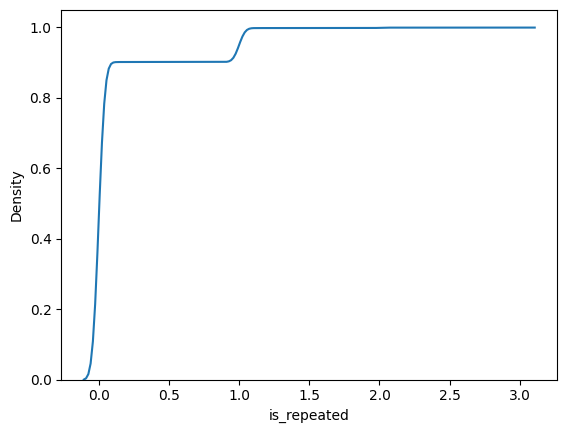

In [147]:
# если в сессии в корзине были айтемы, которые не были ни разу повторно добавлены в корзину одним и тем же юзером
# то на тестовом периоде они не будут добавлены в корзину повторно с вероятностью >90%
sns.kdeplot(tmp.query("n_sess_multi_carts == -1")["is_repeated"], cumulative=True)

test not repeated, train repeated - count:  124941


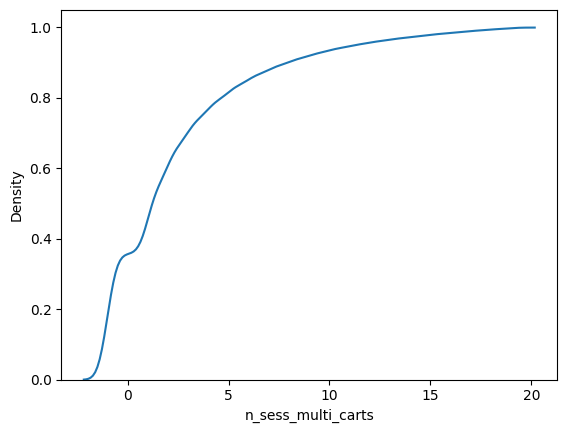

In [139]:
# так же, почти весь товар, который был добавлен в корзину много раз на трейне
# на тестовом периоде может быть ни разу не добавлен повторно
sns.kdeplot(tmp.query("is_repeated == 0 and n_sess_multi_carts < 20")["n_sess_multi_carts"], cumulative=True)
print("test not repeated, train repeated - count: ", tmp.query("is_repeated == 0").shape[0])

In [145]:
print("items in carts in valid_input: ", repeated_buys_with_target.shape)
print(tmp.query("is_repeated == -1").shape, 
    tmp.query("n_sess_multi_carts == -1").shape,
    tmp.query("is_repeated != -1 and n_sess_multi_carts != -1").shape,
)

items in carts in valid_input:  (150378, 2)
(282609, 3) (47718, 3) (102645, 3)


In [141]:
tmp.query("is_repeated == -1 or n_sess_multi_carts == -1")

,aid,n_sess_multi_carts,is_repeated
1,1436608,1,-1
2,1773568,1,-1
3,1680000,1,-1
4,1557824,1,-1
5,1254656,1,-1
...,...,...,...
432982,1656160,-1,0
432983,1712988,-1,0
432984,1569308,-1,0
432985,1509402,-1,0


In [ ]:
sns.kdeplot(tmp.query("is_repeated == -1 and n_sess_multi_carts < 20")["n_sess_multi_carts"], cumulative=True)
print("test not repeated, train repeated - count: ", tmp.query("is_repeated == 0").shape[0])

In [138]:
tmp = (
    repeated_buys.join(repeated_buys_with_target, on="aid", how="outer")
    .fill_null(-1)
    .to_pandas()
    .query("n_sess_multi_carts < 750")
    .query("is_repeated < 100")
)

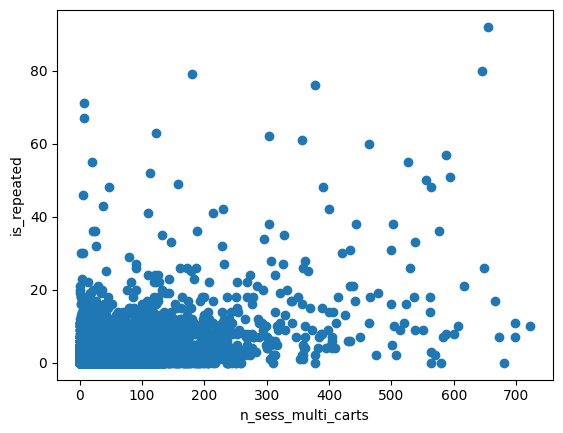

In [117]:
plt.scatter(tmp["n_sess_multi_carts"], tmp["is_repeated"])
plt.xlabel("n_sess_multi_carts")
plt.ylabel("is_repeated")
plt.show()

In [152]:
(
    df_train
    .filter(pl.col("type") == 2)
    .filter(pl.col("aid") == 231487)
)

session,aid,ts,type
i64,i64,i64,i64
81,231487,1659434888443,2
81,231487,1659605780205,2
2567,231487,1660864949892,2
4972,231487,1659439744582,2
4972,231487,1659439744582,2
5570,231487,1660850693960,2
6057,231487,1661128975501,2
6078,231487,1659809954974,2
7919,231487,1660082627957,2


In [161]:
val_df_train

session,aid,ts,type
i64,i64,i64,i64
0,1517085,1659304800025,0
0,1563459,1659304904511,0
0,1309446,1659367439426,0
0,16246,1659367719997,0
0,1781822,1659367871344,0
0,1152674,1659367885796,0
0,1649869,1659369893840,1
0,461689,1659369898050,1
0,305831,1659370027105,2


In [150]:
repeated_buys

aid,n_sess_multi_buys
i64,u32
1787456,1
841344,1
647616,1
1111872,1
1715648,1
1226240,1
835776,1
37376,1
1355456,1


In [178]:
(
    pl.concat([val_df_train, val_df_valid_input])
#     val_df_valid_input
    .groupby(["session", "aid", "type"])
    .agg([pl.n_unique("ts").alias("n_actions")])
    .pivot(values="n_actions", index=["session", "aid"], columns="type")
    .groupby("aid")
    .agg([
        (
            pl.when(pl.col("0") > 1).then(pl.col("session")).otherwise(None).n_unique() - 1
        ).alias("item_n_sess_multi_clicks"),
        (
            pl.when(pl.col("1") > 1).then(pl.col("session")).otherwise(None).n_unique() - 1
        ).alias("item_n_sess_multi_carts"),
        (
            pl.when(pl.col("2") > 1).then(pl.col("session")).otherwise(None).n_unique() - 1
        ).alias("item_n_sess_multi_buys"),
    ])
# #     .filter(pl.col("n_buys") > 1)
#     .groupby(["aid"])
#     .agg([pl.count("session").alias("n_sess_multi_buys")])
#     .sort("n_sess_multi_buys")
)

aid,item_n_sess_multi_clicks,item_n_sess_multi_carts,item_n_sess_multi_buys
i64,u32,u32,u32
424896,11,1,0
208640,2,0,0
316608,1,0,0
1837248,1,0,0
448256,1,1,0
1783552,4,0,0
1177280,0,1,0
39616,3,0,0
57408,1,0,0


In [148]:
# count content that positive (1, 2) more than 1 time
repeated_buys = (
    pl.concat([val_df_train, val_df_valid_input])
    .filter(pl.col("type") == 2)
    .groupby(["session", "aid"])
    .agg([pl.count("ts").alias("n_buys")])
    .filter(pl.col("n_buys") > 1)
    .groupby(["aid"])
    .agg([pl.count("session").alias("n_sess_multi_buys")])
    .sort("n_sess_multi_buys")
)

repeated_carts = (
    pl.concat([val_df_train, val_df_valid_input])
    .filter(pl.col("type") == 1)
    .groupby(["session", "aid"])
    .agg([pl.count("ts").alias("n_buys")])
    .filter(pl.col("n_buys") > 1)
    .groupby(["aid"])
    .agg([pl.count("session").alias("n_sess_multi_carts")])
    .sort("n_sess_multi_carts")
)

In [153]:
repeated_buys_with_target

aid,is_repeated
i64,u32
1374080,0
271168,0
1728,0
1303872,0
1685120,1
1789632,0
1481280,0
678208,0
1420352,1


In [154]:
aids_temp = Counter()

In [157]:
aids_temp[0] = 0.1
aids_temp[0] += 0.4

aids_temp[1] += 0.04
aids_temp[1] += 0.14

aids_temp[2] += 0.34
aids_temp[2] += 0.14

In [159]:
aids_temp.most_common(2)

[(0, 0.5), (2, 0.48000000000000004)]

In [ ]:
all_buys_with_target = (
    val_df_valid_targets.filter(pl.col("type") == "carts")
    .with_columns([pl.col("aid").is_in(pl.col("ground_truth")).alias("is_repeated")])
    .groupby("aid")
    .agg([pl.sum("is_repeated")])
)

In [106]:
repeated_buys_with_target = (
    val_df_valid_input.filter(pl.col("type") == 1)
    .join(val_df_valid_targets.filter(pl.col("type") == "carts"), on="session")
    .with_columns([pl.col("aid").is_in(pl.col("ground_truth")).alias("is_repeated")])
    .groupby("aid")
    .agg([pl.sum("is_repeated")])
)

In [102]:
(
    val_df_valid_input.filter(pl.col("type") == 1)
    .join(val_df_valid_targets, on="session")
    .with_columns([pl.col("aid").is_in(pl.col("ground_truth")).alias("is_repeated")])
)

session,aid,ts,type,type_right,ground_truth,is_repeated
i64,i64,i64,i64,str,list[i64],bool
11107744,1556644,1661126439064,1,"""clicks""",[1075085],false
11107744,1556644,1661126439064,1,"""carts""","[165989, 178869, ... 1075085]",false
11107747,543120,1661460004151,1,"""clicks""",[618078],false
11107761,355300,1661126473852,1,"""clicks""",[1789315],false
11107761,950341,1661126549811,1,"""clicks""",[1789315],false
11107761,559821,1661126621142,1,"""clicks""",[1789315],false
11107761,411027,1661126781266,1,"""clicks""",[1789315],false
11107761,1510588,1661126923131,1,"""clicks""",[1789315],false
11107761,129997,1661126974684,1,"""clicks""",[1789315],false


In [99]:
val_df_valid_input.filter(pl.col("type") == 1)

session,aid,ts,type
i64,i64,i64,i64
11107744,1556644,1661126439064,1
11107761,355300,1661126473852,1
11107788,432527,1661126494252,1
11107778,1693230,1661126511845,1
11107793,1296823,1661126525997,1
11107761,950341,1661126549811,1
11107827,1426828,1661126551565,1
11107778,1392023,1661126572652,1
11107788,125994,1661126587045,1


In [97]:
val_df_valid_targets

session,type,ground_truth
i64,str,list[i64]
11107743,"""clicks""",[224347]
11107744,"""clicks""",[1075085]
11107744,"""carts""","[165989, 178869, ... 1075085]"
11107745,"""clicks""",[549612]
11107746,"""clicks""",[1750662]
11107747,"""clicks""",[618078]
11107748,"""clicks""",[1551520]
11107749,"""clicks""",[153565]
11107750,"""clicks""",[184976]


In [95]:
(
    df_train
    .filter(pl.col("type") == 1)
    .filter(pl.col("aid") == 1811520)
)

session,aid,ts,type
i64,i64,i64,i64
245557,1811520,1661161024151,1
786267,1811520,1659395039556,1
786267,1811520,1659445011627,1
786267,1811520,1659445038726,1
1120005,1811520,1661094645049,1


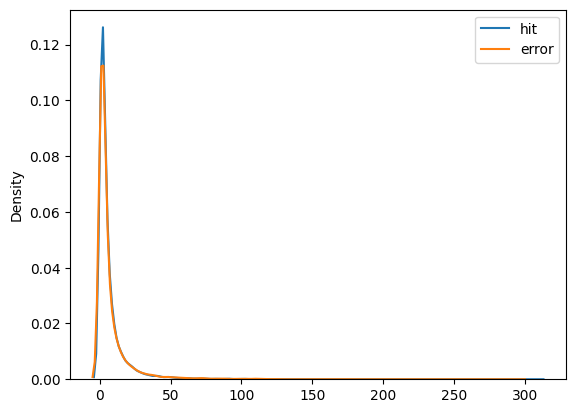

In [52]:
errors_predicted_sess_len = (
    pl.from_pandas(valid_stats.query("hits == 0 and gt_count > 0"))
    .join(session_stats, on="session")
    ["sess_len"].to_numpy()
)

hits_predicted_sess_len = (
    pl.from_pandas(valid_stats.query("hits > 0 and gt_count > 0"))
    .join(session_stats, on="session")
    ["sess_len"].to_numpy()
)

sns.kdeplot(hits_predicted_sess_len, label="hit")
sns.kdeplot(errors_predicted_sess_len, label="error")
plt.legend()
plt.show()

In [20]:
val_df_valid_input["session"].max() - val_df_valid_input["session"].min()

1792034

In [41]:
df_train.filter(pl.col("session") == 11107746)

session,aid,ts,type
i64,i64,i64,i64
11107746,1134602,1661126404790,0
11107746,795232,1661126527755,0
11107746,1750662,1661126566705,0


In [25]:
val_df_valid_input.filter(pl.col("session") == 11107744)

session,aid,ts,type
i64,i64,i64,i64
11107744,220086,1661126401190,0
11107744,1556644,1661126439064,1
11107744,1637748,1661126441080,0
11107744,1556644,1661126463911,0


In [36]:
clicks_top.filter(pl.col("aid") == 1556644)

aid,aid_right,weight,ones,rank
i64,i64,f64,i32,i32
1556644,830498,116.6018,1,1
1556644,263196,66.545957,1,2
1556644,220086,48.237438,1,3
1556644,750573,40.194685,1,4
1556644,1510820,31.890013,1,5
1556644,959553,30.129692,1,6
1556644,813313,24.940581,1,7
1556644,497882,24.870012,1,8
1556644,714397,19.057462,1,9


In [37]:
carts_orders_top.filter(pl.col("aid") == 1556644)

aid,aid_right,weight,ones,rank
i64,i64,f64,i32,i32
1556644,830498,82.5,1,1
1556644,959553,70.5,1,2
1556644,220086,45.5,1,3
1556644,1510820,25.0,1,4
1556644,497882,23.5,1,5
1556644,813313,22.0,1,6
1556644,728982,20.5,1,7
1556644,618186,19.0,1,8
1556644,750573,17.0,1,9


In [31]:
buys2buys_top.filter(pl.col("aid") == 178869)

aid,aid_right,weight,ones,rank
i64,i64,i32,i32,i32
178869,2532,6,1,1
178869,1744584,4,1,2
178869,117765,4,1,3
178869,1027112,4,1,4
178869,960540,3,1,5
178869,483382,3,1,6
178869,1170007,3,1,7
178869,445892,2,1,8
178869,36237,2,1,9
